In [351]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
%matplotlib inline
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels
import pandas as pd
import numpy as np
from tensorflow_probability import distributions as tfd
import time
np.set_printoptions(precision=3,suppress=True)

In [352]:
X = np.load('X.npy')
X = np.r_[X[:,[0,2]],X[:,[0,3]]]
Y = np.load('Y.npy')
S = max(X[:,1])+1
#L = max(X[:,1])+1
M = 8
Z = np.linspace(0,50,M)[None,:]
Z = np.repeat(Z,S,0)
Z = Z.flatten()[:,None]
Z = np.c_[Z,np.repeat(np.arange(S),M)]

In [513]:
class Kernel():
    def k(self,x1,x2):
        return 2.0**2*np.exp(-(x1-x2)**2/(2*50.0**2))+4
    
    def matrix(self,X1,X2):
        try:
            X1 = X1.numpy()
            X2 = X2.numpy()
        except AttributeError:
            pass
        r = np.zeros([X1.shape[0],X2.shape[0]])
        for i1,x1 in enumerate(X1):
            for i2,x2 in enumerate(X2):
                    if x1[1]==x2[1]: #if same sensor
                        r[i1,i2] = self.k(x1[0],x2[0])
        return tf.Variable(r,dtype=tf.float32)


In [514]:
#definition of q(u)
m = Z.shape[0]
mu = tf.Variable(0.01*tf.random.normal([m,1]))
scale = tf.Variable(1*np.tril(0.1*np.random.randn(m, m)+np.eye(m)),dtype=tf.float32)

k = Kernel()

#parameters for p(u)
mu_u = tf.zeros([m],dtype=tf.float32)
cov_u = tf.Variable(k.matrix(Z,Z),dtype=tf.float32)

jitter = 1e-4
pu = tfd.MultivariateNormalFullCovariance(mu_u,cov_u+np.eye(cov_u.shape[0])*jitter)
Kzz = k.matrix(Z,Z)+np.eye(Z.shape[0],dtype=np.float32)*jitter
Kxx = k.matrix(X,X)+np.eye(X.shape[0],dtype=np.float32)*jitter
Kxz = k.matrix(X,Z)
Kzx = tf.transpose(Kxz)
KzzinvKzx = tf.linalg.solve(Kzz,Kzx)
KxzKzzinv = tf.transpose(KzzinvKzx)
KxzKzzinvKzx = Kxz @ KzzinvKzx
N = int(X.shape[0]/2)

In [515]:
def getcov(scale):
    return tf.linalg.band_part(scale, -1, 0) @ tf.transpose(tf.linalg.band_part(scale, -1, 0))

In [516]:
refsensor = np.array([1,0,0,0,0]).astype(np.float32)

In [517]:
ref = tf.gather(refsensor,tf.transpose(tf.reshape(X[:,1:2],[2,N])))


In [518]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01,amsgrad=False)

In [522]:
starttime = time.time()

for it in range(500):

    with tf.GradientTape() as tape:
        qu = tfd.MultivariateNormalTriL(mu[:,0],scale)
        
        qf_mu = KxzKzzinv @ mu
        qf_cov = Kxx - KxzKzzinvKzx + KxzKzzinv @ getcov(scale) @ KzzinvKzx
        batched_mu = tf.transpose(tf.reshape(qf_mu,[2,N]))
        batched_cov = [[tf.linalg.diag_part(qf_cov[:N,:N]),tf.linalg.diag_part(qf_cov[N:,:N])],[tf.linalg.diag_part(qf_cov[:N,N:]),tf.linalg.diag_part(qf_cov[N:,N:])]]
        samps = tfd.MultivariateNormalFullCovariance(batched_mu,tf.transpose(batched_cov)+tf.eye(2)*jitter).sample(1000)
        scaled = ((tf.exp(samps) * Y) * (1-ref)) + (Y * ref)  #(tf.exp(samps) * Y)
        #ell = tf.reduce_mean(tf.reduce_sum(tfd.Normal(0,1.0).log_prob(scaled[:,:,0]-scaled[:,:,1]),1))
        ell = tf.reduce_mean(tf.reduce_sum(tfd.Normal(1.0,0.1).log_prob(scaled[:,:,0]/scaled[:,:,1]),1))
        elbo_loss = -ell+tfd.kl_divergence(qu,pu)
        gradients = tape.gradient(elbo_loss, [mu,scale])
        optimizer.apply_gradients(zip(gradients, [mu, scale]))

    if it%50==0: 
        print("%4d %0.1f %8.0f %8.0f %8d" % (it,elbo_loss.numpy(),gradients[0].numpy()[0,0],gradients[1].numpy()[0,0],int(time.time()-starttime)))
        #print(mu.numpy()[::10].T)

   0 -41.3       -0       -0        0
  50 -42.8       -2       -0        1
 100 -44.8       -0       -0        3
 150 -46.2       -0       -0        5
 200 -47.6        0       -0        7
 250 -48.7       -0       -0        9
 300 -49.9       -6       -0       10
 350 -50.3       -0       -0       12
 400 -51.4        0       -0       14
 450 -52.2       -0       -0       16


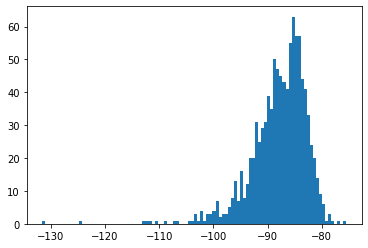

In [523]:
#plt.hist(tfd.Normal(0,1.0).log_prob(scaled[:,:,0]-scaled[:,:,1]).numpy().flatten(),100);
plt.hist(tf.reduce_sum(tfd.Normal(0,1.0).log_prob(scaled[:,:,0]-scaled[:,:,1]),1),100);

In [524]:
ell,tfd.kl_divergence(qu,pu)

(<tf.Tensor: shape=(), dtype=float32, numpy=83.14143>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.491064>)

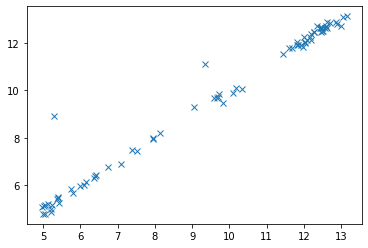

In [525]:
s = tf.reduce_mean(scaled,0)
plt.plot(s[:,0],s[:,1],'x')

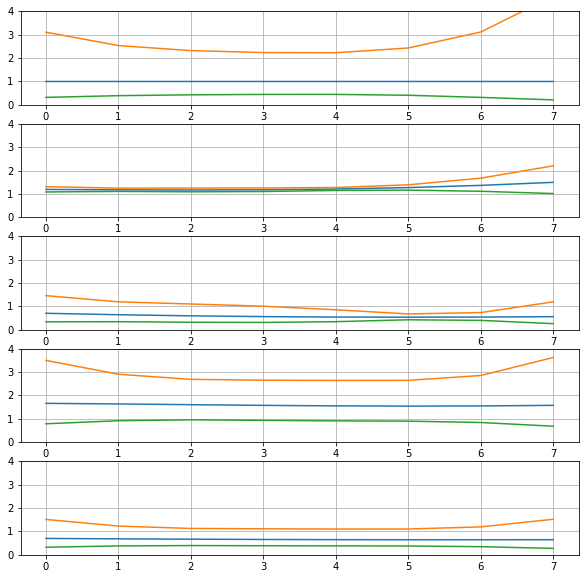

In [526]:
plt.figure(figsize=[10,10])
np.diag(getcov(scale))
for i,(d,v) in enumerate(zip(np.reshape(mu.numpy(),[S,M]),np.reshape(np.diag(getcov(scale)),[S,M]))):
    plt.subplot(5,1,i+1)
    plt.plot(1/np.exp(d))
    plt.plot(1/np.exp(d-2*np.sqrt(v)))
    plt.plot(1/np.exp(d+2*np.sqrt(v)))
    plt.grid()
    plt.ylim([0,4])

In [325]:
sensor0=ref
sensor1=*1.2
sensor2=*0.5
sensor3=*1.2
sensor4=*0.5

SyntaxError: can't use starred expression here (<ipython-input-325-6265d43d23a8>, line 2)

In [207]:
Y

array([[ 7.093,  8.208],
       [ 5.95 , 14.248],
       [ 7.523,  8.865],
       [ 6.199, 14.915],
       [ 7.941,  9.507],
       [ 6.495, 15.504],
       [ 8.147,  9.74 ],
       [ 6.612, 15.742],
       [ 7.952,  9.428],
       [ 6.484, 15.489],
       [ 7.39 ,  8.856],
       [ 6.185, 14.866],
       [ 6.75 ,  7.989],
       [ 5.938, 17.712],
       [ 5.995,  7.023],
       [19.12 ,  7.894],
       [ 5.398,  6.411],
       [18.441,  7.714],
       [ 5.046,  6.062],
       [18.108,  7.624],
       [ 5.022,  6.029],
       [18.016,  7.53 ],
       [ 5.397,  6.461],
       [18.42 ,  7.632],
       [ 5.124,  6.155],
       [18.174,  7.549],
       [ 4.973,  5.991],
       [17.986,  7.528],
       [ 5.247,  6.1  ],
       [18.169,  7.582],
       [ 5.376,  6.45 ],
       [18.488,  7.783],
       [ 5.75 ,  6.944],
       [18.923,  7.988],
       [ 6.147,  7.329],
       [19.371,  7.973],
       [ 6.384,  7.676],
       [19.641,  7.977],
       [ 6.421,  7.773],
       [19.72 ,  8.219],


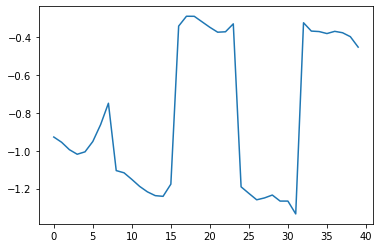

In [205]:
plt.plot(mu[:,0])

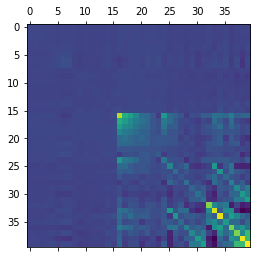

In [115]:
plt.matshow(getcov(scale))